In [1]:
setwd('/import/liujing/data/scRNA/')
scRNA = readRDS('scRNA.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [3]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
Attaching SeuratObject



In [5]:
scRNA

An object of class Seurat 
37487 features across 65790 samples within 1 assay 
Active assay: RNA (37487 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, tsne

In [6]:
scedata = scRNA

In [7]:
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数


HBP-1.matrix HBP-2.matrix HBP-3.matrix HBP-4.matrix HBP-5.matrix HBP-6.matrix 
        5210         3692         5069         4233         6584         6225 
 QG-1.matrix  QG-2.matrix  QG-3.matrix  QG-4.matrix  QG-5.matrix  QG-6.matrix 
        3874         4454         5084         4916         6833         4118 
 QG-7.matrix  QG-8.matrix 
        1137         4361 


 Neutrophils      T_cells     Monocyte      NK_cell       B_cell 
0.9437148503 0.0374829001 0.0077823377 0.0106247150 0.0003951968 

             
              HBP-1.matrix HBP-2.matrix HBP-3.matrix HBP-4.matrix HBP-5.matrix
  Neutrophils         5140         3591         4088         3735         6516
  T_cells               31           42          809          325           28
  Monocyte              28           15          110           55           11
  NK_cell               11           44           54          116           28
  B_cell                 0            0            8            2            1
             
              HBP-6.matrix QG-1.matrix QG-2.matrix QG-3.matrix QG-4.matrix
  Neutrophils         6070        3718        4240        4659        4791
  T_cells               59          85         170         313          90
  Monocyte               9          43          17          75          19
  NK_cell               86          26          25          31          16
  B_cell                 1           2           2           6           0
             
              QG-5.matrix QG-6.mat

In [8]:
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- data.frame(Cellratio)

In [9]:
library(reshape2)
cellper <- dcast(Cellratio,Var2~Var1, value.var = "Freq")#长数据转为宽数据
rownames(cellper) <- cellper[,1]
cellper <- cellper[,-1]

Warning message:
"package 'reshape2' was built under R version 4.2.3"


In [11]:
###添加分组信息
sample <- rownames(cellper)

In [12]:
sample

[1] "HBP-1.matrix" "HBP-2.matrix" "HBP-3.matrix" "HBP-4.matrix" "HBP-5.matrix"
 [6] "HBP-6.matrix" "QG-1.matrix"  "QG-2.matrix"  "QG-3.matrix"  "QG-4.matrix" 
[11] "QG-5.matrix"  "QG-6.matrix"  "QG-7.matrix"  "QG-8.matrix"

In [17]:
group <- c(rep('HBP',6),rep('LS',8))

In [18]:

samples <- data.frame(sample, group)#创建数据框

In [19]:
rownames(samples)=samples$sample
cellper$sample <- samples[rownames(cellper),'sample']#R添加列
cellper$group <- samples[rownames(cellper),'group']#R添加列

In [20]:
###作图展示
pplist = list()
sce_groups = unique(scRNA$celltype)

In [26]:
library(ggplot2)
library(dplyr)
library(ggpubr)
library(cowplot)
for(group_ in sce_groups){
  cellper_  = cellper %>% select(one_of(c('sample','group',group_)))#选择一组数据
  colnames(cellper_) = c('sample','group','percent')#对选择数据列命名
  cellper_$percent = as.numeric(cellper_$percent)#数值型数据
  cellper_ <- cellper_ %>% group_by(group) %>% mutate(upper =  quantile(percent, 0.75), 
                                                      lower = quantile(percent, 0.25),
                                                      mean = mean(percent),
                                                      median = median(percent))#上下分位数
  print(group_)
  print(cellper_$median)
  
  pp1 = ggplot(cellper_,aes(x=group,y=percent)) + #ggplot作图
    geom_jitter(shape = 21,aes(fill=group),width = 0.25) + 
    stat_summary(fun=mean, geom="point", color="grey60") +
    theme_cowplot() +
    theme(axis.text = element_text(size = 10),axis.title = element_text(size = 10),legend.text = element_text(size = 10),
          legend.title = element_text(size = 10),plot.title = element_text(size = 10,face = 'plain'),legend.position = 'none') + 
    labs(title = group_,y='Percentage') +
    geom_errorbar(aes(ymin = lower, ymax = upper),col = "grey60",width =  1)
  
  ###组间t检验分析
  labely = max(cellper_$percent)
  compare_means(percent ~ group,  data = cellper_)
  my_comparisons <- list( c("HBP", "LS") )
  pp1 = pp1 + stat_compare_means(comparisons = my_comparisons,size = 3,method = "t.test")
  pplist[[group_]] = pp1
}

[1] "Neutrophils"
 [1] 0.9738720 0.9738720 0.9738720 0.9738720 0.9738720 0.9738720 0.9558424
 [8] 0.9558424 0.9558424 0.9558424 0.9558424 0.9558424 0.9558424 0.9558424
[1] "T_cells"
 [1] 0.01042693 0.01042693 0.01042693 0.01042693 0.01042693 0.01042693
 [7] 0.03005454 0.03005454 0.03005454 0.03005454 0.03005454 0.03005454
[13] 0.03005454 0.03005454
[1] "Monocyte"
 [1] 0.004718559 0.004718559 0.004718559 0.004718559 0.004718559 0.004718559
 [7] 0.008350366 0.008350366 0.008350366 0.008350366 0.008350366 0.008350366
[13] 0.008350366 0.008350366
[1] "NK_cell"
 [1] 0.011285324 0.011285324 0.011285324 0.011285324 0.011285324 0.011285324
 [7] 0.005855247 0.005855247 0.005855247 0.005855247 0.005855247 0.005855247
[13] 0.005855247 0.005855247
[1] "B_cell"
 [1] 0.0001562630 0.0001562630 0.0001562630 0.0001562630 0.0001562630
 [6] 0.0001562630 0.0003459355 0.0003459355 0.0003459355 0.0003459355
[11] 0.0003459355 0.0003459355 0.0003459355 0.0003459355


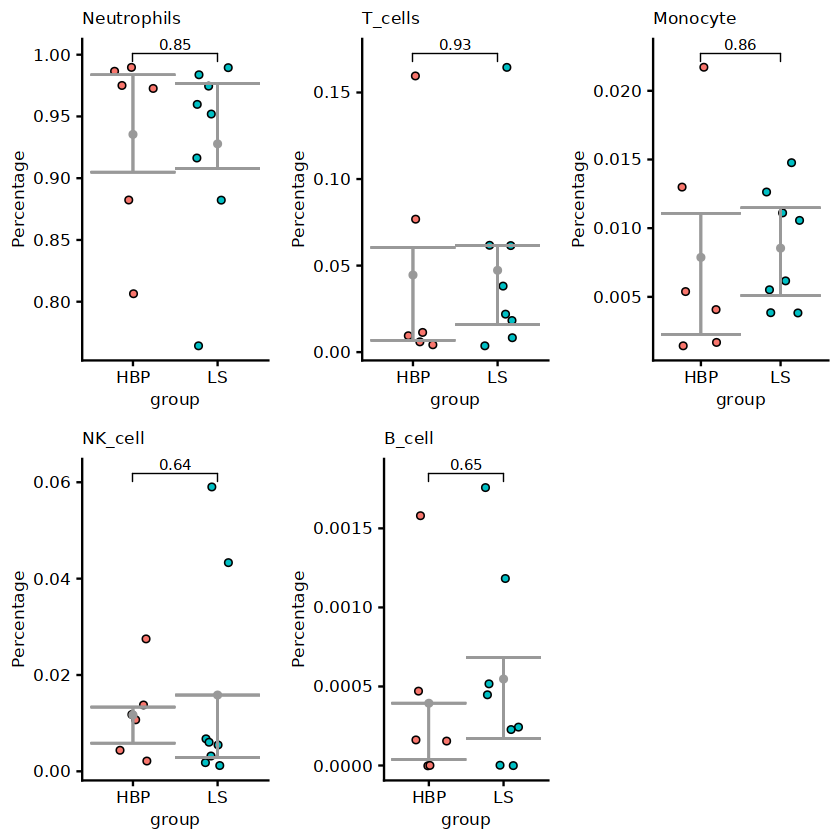

In [32]:
 library(cowplot)
plot_grid(pplist[[1]],
          pplist[[2]],
          pplist[[3]],
          pplist[[4]],
          pplist[[5]])
